# Model validation


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import TimeSeriesSplit

import sys

sys.path.append("..")

from utils.custom_cvs import VariableTimeSeriesSplit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Target attributes


For the validation of the model, it will be tested with different target attributes, specifically

- Final position of the driver
- Final position of the driver in a ±1 interval
- Final position of the driver in fixed intervals of size 3
- The driver is winner or not
- The driver is podium or not

But first we have to do another preprocessing to obtain the training attributes.


## Train and test splits


First, we will first have to order the instances to carry out the training of the model.


In [2]:
df = pd.read_csv("../assets/data/processed/missing_values.csv")
df = df.sort_values(by=["raceYear", "raceRound"]).reset_index(drop=True)

Training will be done with walkforward, whose scikit instance that implements it is TimeSeriesSplit.


In [3]:
X_tscv = pd.DataFrame([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
tscv = TimeSeriesSplit(n_splits=2, max_train_size=3, test_size=1)

for train, test in tscv.split(X_tscv):
    print("%s %s" % (train, test))

[1 2 3] [4]
[2 3 4] [5]


However, the time intervals offered by TimeSeriesSplit are fixed, i.e. there cannot be more instances in one interval than in another. In our case, we have that every F1 season there can be more or less instances due to the variation of the drivers as well as the number of races. This can be seen below


In [4]:
instances_per_year = df["raceYear"].value_counts(sort=False)
instances_per_year

raceYear
2006    396
2007    374
2008    368
2009    340
2010    456
2011    456
2012    480
2013    418
2014    407
2015    378
2016    462
2017    400
2018    420
2019    420
2020    340
2021    440
2022    440
2023    240
Name: count, dtype: int64

Therefore, another class has been created extending TimeSeriesSplit that allows the variation of instances in each of the intervals, VariableTimeSeriesSplit. It has been created in an external file so as not to dirty the notebook.

First, let's see that the behavior is the same with the same parameters called above with TimeSeriesSplit.


In [5]:
tscv = VariableTimeSeriesSplit(n_splits=2, max_train_size=3, test_size=1)

for train, test in tscv.split(X_tscv):
    print("%s %s" % (train, test))

[1 2 3] [4]
[2 3 4] [5]


Now we will check the case of F1 seasons. Notice that half-seasons will be considered instead of full seasons.


In [6]:
instances_per_half = (
    np.array(
        list(zip(np.floor(instances_per_year / 2), np.ceil(instances_per_year / 2)))
    )
    .flatten()
    .astype(np.int32)
)
instances_per_half

array([198, 198, 187, 187, 184, 184, 170, 170, 228, 228, 228, 228, 240,
       240, 209, 209, 203, 204, 189, 189, 231, 231, 200, 200, 210, 210,
       210, 210, 170, 170, 220, 220, 220, 220, 120, 120])

In [7]:
n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

get_years = lambda x: ",".join(
    df.iloc[x]["raceYear"].drop_duplicates().to_numpy(dtype=str)
)

for i, (tr, ts) in enumerate(tscv.split(df)):
    if i <= 6 or i >= 24:
        print(f"Split {i+1}-th:")
        print(f"-> Train years (from {tr[0]} to {tr[len(tr)-1]}): {get_years(tr)}")
        print(f"-> Test years (from {ts[0]} to {ts[len(ts)-1]}): {get_years(ts)}")
        print()
    elif i == 7:
        print("...\n")

Split 1-th:
-> Train years (from 0 to 1933): 2006,2007,2008,2009,2010
-> Test years (from 1934 to 2161): 2011

Split 2-th:
-> Train years (from 198 to 2161): 2006,2007,2008,2009,2010,2011
-> Test years (from 2162 to 2389): 2011

Split 3-th:
-> Train years (from 396 to 2389): 2007,2008,2009,2010,2011
-> Test years (from 2390 to 2629): 2012

Split 4-th:
-> Train years (from 583 to 2629): 2007,2008,2009,2010,2011,2012
-> Test years (from 2630 to 2869): 2012

Split 5-th:
-> Train years (from 770 to 2869): 2008,2009,2010,2011,2012
-> Test years (from 2870 to 3078): 2013

Split 6-th:
-> Train years (from 954 to 3078): 2008,2009,2010,2011,2012,2013
-> Test years (from 3079 to 3287): 2013

Split 7-th:
-> Train years (from 1138 to 3287): 2009,2010,2011,2012,2013
-> Test years (from 3288 to 3490): 2014

...

Split 25-th:
-> Train years (from 4935 to 6994): 2018,2019,2020,2021,2022
-> Test years (from 6995 to 7114): 2023

Split 26-th:
-> Train years (from 5145 to 7114): 2018,2019,2020,2021,2022,2

## Encoding and normalization


Finally, before we start training the models with each target attribute, we have to encode the categorical attributes of the dataframe.


In [8]:
X = df.drop(
    [
        "positionFinal",
        "pointsDriverEarned",
        "lapsCompleted",
        "timeTakenInMillisec",
        "fastestLap",
        "fastestLapRank",
        "fastestLapTime",
        "maxSpeed",
        "driverStatus",
        "pointsConstructorEarned",
        "constructorPosition",
    ],
    axis=1,
)

enc = LabelEncoder()
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = enc.fit_transform(X[c])

First, we will check if the values are in similar range in order to apply models that depend on normalization.


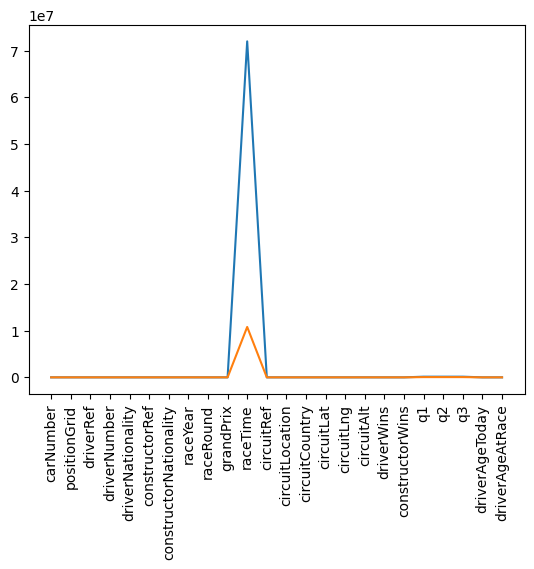

In [9]:
maxs, mins = X.max(), X.min()

ext_inf = 0
ext_sup = len(X.columns)

plt.plot(maxs[ext_inf:ext_sup])
plt.plot(mins[ext_inf:ext_sup])

plt.xticks(ticks=range(ext_sup - ext_inf), labels=X.columns, rotation=90)
plt.show()

We can see that, indeed, we need to normalize the data. For this purpose, RobustScaler will be used since, after some tests, it is the one with which the best results have been obtained and it keeps the outliers separated from the inliers.


In [10]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

Let's look again at the range of values.


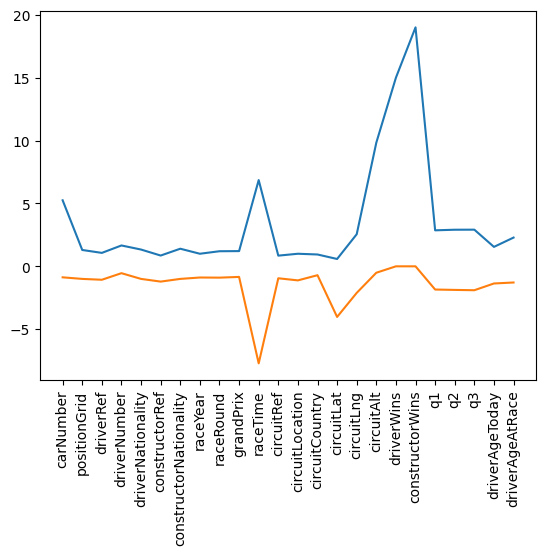

In [11]:
maxs, mins = X.max(), X.min()

ext_inf = 0
ext_sup = len(X.columns)

plt.plot(maxs[ext_inf:ext_sup])
plt.plot(mins[ext_inf:ext_sup])

plt.xticks(ticks=range(ext_sup - ext_inf), labels=X.columns, rotation=90)
plt.show()

Finally, we write down the results for later sections


In [12]:
df.to_csv("../assets/data/processed/base_model.csv", index=False)
X.to_csv("../assets/data/processed/base_model_X.csv", index=False)